In [1]:
import cv2
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from glob import iglob

from sklearn.decomposition import PCA, FastICA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# Read image files
def read_images(directory_name):
    X = []; y = []
    for image in iglob("feret_dataset/" + directory_name + "/*.pgm"):
        face = cv2.resize(plt.imread(image), (50, 60)).flatten()
        X = np.append(X, face)
        y = np.append(y, image.split("/")[2][:5])
    X = np.reshape(X, (-1, 3000))
    return X, y

In [3]:
# Center features by removing the mean
def center(X):
    return X - np.mean(X, axis=0)

# Standardize features by scaling to unit variance
def standardize(X):
    return X / np.std(X, axis=0)

# Decorrelate components of X
def whiten(X):
    X = center(X)
    eigval, eigvec, = np.linalg.eig(np.cov(X.T))
    K = eigvec @ np.diag(1 / np.sqrt(eigval+1e-9)) @ eigvec.T
    return K @ X.T, K

In [4]:
# Order the eigenvectors according to the magnitude of the eigenvalues
def order_eigenpairs(eigval, eigvec):
    eigpairs = [(eigval[i], eigvec[:,i]) for i in range(len(eigval))]
    eigpairs.sort(reverse=True)
    eigval = np.array([elem.real for elem,_ in eigpairs])
    eigvec = np.array([elem.real for _,elem in eigpairs])
    return eigval, eigvec

# Print cumulative variance of the first n eigenvalues
def cum_var(eigval, n_eigvals):
    print("The cumulative variance of the first " + str(n_eigvals) + " principal components is: " + str(np.sum(eigval[:n_eigvals]) / np.sum(eigval) * 100))

# Perform Principal Component Analysis
def get_principal_components(X, n_components, print_var): # data(n_samples, n_features)
    X = X.T
    # Compute eigenvalues and eigenvectors of covariance matrix
    eigval, eigvec, = np.linalg.eig(np.cov(X))
    eigval, eigvec = order_eigenpairs(eigval, eigvec)
    if print_var:
        cum_var(eigval, n_components)
    # Compute the Principal Component space
    pcspace = eigvec[:n_components].T
    return pcspace

In [5]:
# Kurtosis funtion
def g(u):
    return 4 * u**3

# Derivated kurtosis function
def dg(u):
    return 12 * u**2

# Compute one Independent Component
def compute_unit(X, W):
    w = np.random.rand(X.shape[0])
    w /= np.linalg.norm(w)
    for iter in range(5000):
        w0 = w
        w = (1 / X.shape[1]-1) * X @ g(w.T @ X).T - (1 / X.shape[1]-1) * dg(w.T @ X) @ np.ones((X.shape[1], 1)) * w
        for w_ in W:
            w = w - w.T @ w_ * w_
        w /= np.linalg.norm(w) 
        # Check for convergence
        if (1 - np.abs(w0.T @ w) < 1e-10):
            break
    return w

# Perform Independent Component Analysis 1
def get_independent_components1(X, n_components):
    X = X.T
    X, K = whiten(X)
    W = []
    for i in range(n_components):
        w = compute_unit(X, W)
        W.append(w)
    return np.array(W) @ K

# Perform Independent Component Analysis 2
def get_independent_components2(X, n_components):
    X, K = whiten(X)
    W = []
    for i in range(n_components):
        w = compute_unit(X, W)
        W.append(w)
    return np.array(W) @ K

In [6]:
# Calculate the performance of an algorithms wrt a measure
def performance(nn, X_pr, y_pr, X_gal, y_gal, rank):
    true = 0
    total = X_pr.shape[0]
    for i in range(total):
        if y_pr[i] in [y_gal[i] for i in nn.kneighbors(X=[X_pr[i]], n_neighbors=rank)[1][0]]:
            true += 1
    return round(true / total * 100, 2)

# Create a CSM plot
def CSM(nn, probe, gallery):
    csm = []
    for rank in range(0, 81, 5):
        if rank == 0:
            csm.append(performance(nn, probe, gallery, rank+1))
        else:
            csm.append(performance(nn, probe, gallery, rank))
    return csm

In [7]:
# Display scatterplot of the data
def plot_data(X, title):
    plt.scatter(X[:, 0], X[:, 1], s=5, color='steelblue', alpha=0.5)
    plt.hlines(0, -3, 3); plt.vlines(0, -3, 3)
    plt.xlim(-3, 3); plt.ylim(-3, 3)
    plt.title(title)
    
# Display a list of vectors on a plot
def plot_vectors(vectors, labels):
    colors = ['orange', 'red']
    for color, vector in zip(colors, vectors):
        vector /= vector.std()
        x_axis, y_axis = vector
        plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
        plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6, color=color)
    legend = plt.legend(labels, loc='upper right')
    legend.set_zorder(100)

# Display the results of experiments
def create_report(X, X_, pca_skl, pca_nbk, ica_skl, ica_nbk):
    plt.figure(figsize=(15, 20))
    plt.subplot(321)
    plot_data(X / X.std(), "Initial data")
    plt.subplot(322)
    plot_data(X_ / X_.std(), "Mixed data")
    plt.subplot(323)
    plot_data(standardize(pca_skl), "Scikit-learn PCA Recovered Signals")
    plt.subplot(324)
    plot_data(standardize(X_ @ pca_nbk), "Notebook PCA Recovered Signals")
    plt.subplot(325)
    plot_data(standardize(ica_skl), "Scikit-learn ICA Recovered Signals")
    plt.subplot(326)
    plot_data(standardize(X_ @ ica_nbk.T), "Notebook ICA Recovered Signals")
    plt.show()

# Conduct a test to check the accuracy of ICA and PCA on a dummy dataset
def dummy_test():
    # Create a 2-d dataset that follows a Student's t-distribution and preprocess it
    rng = np.random.RandomState(23)
    X = rng.standard_t(1.5, size=(20000, 2))
    X[:, 0] *= 2.
    X = center(X); X = standardize(X)
    # Mix the independent sources
    A = np.array([[1, 1], [0, 2]])
    X_ = X @ A.T
    # Perform PCA through both sklearn and the method in this notebook
    pca = PCA()
    pca_skl = pca.fit(X_).transform(X_)
    pca_nbk = get_principal_components(X_, 2, False)
    # Perform ICA through both sklearn and the method in this notebook
    ica = FastICA(random_state=rng)
    ica_skl = ica.fit(X_).transform(X_)
    ica_nbk = get_independent_components2(X_, 2)
    # Display results
    create_report(X, X_, pca_skl, pca_nbk, ica_skl, ica_nbk)

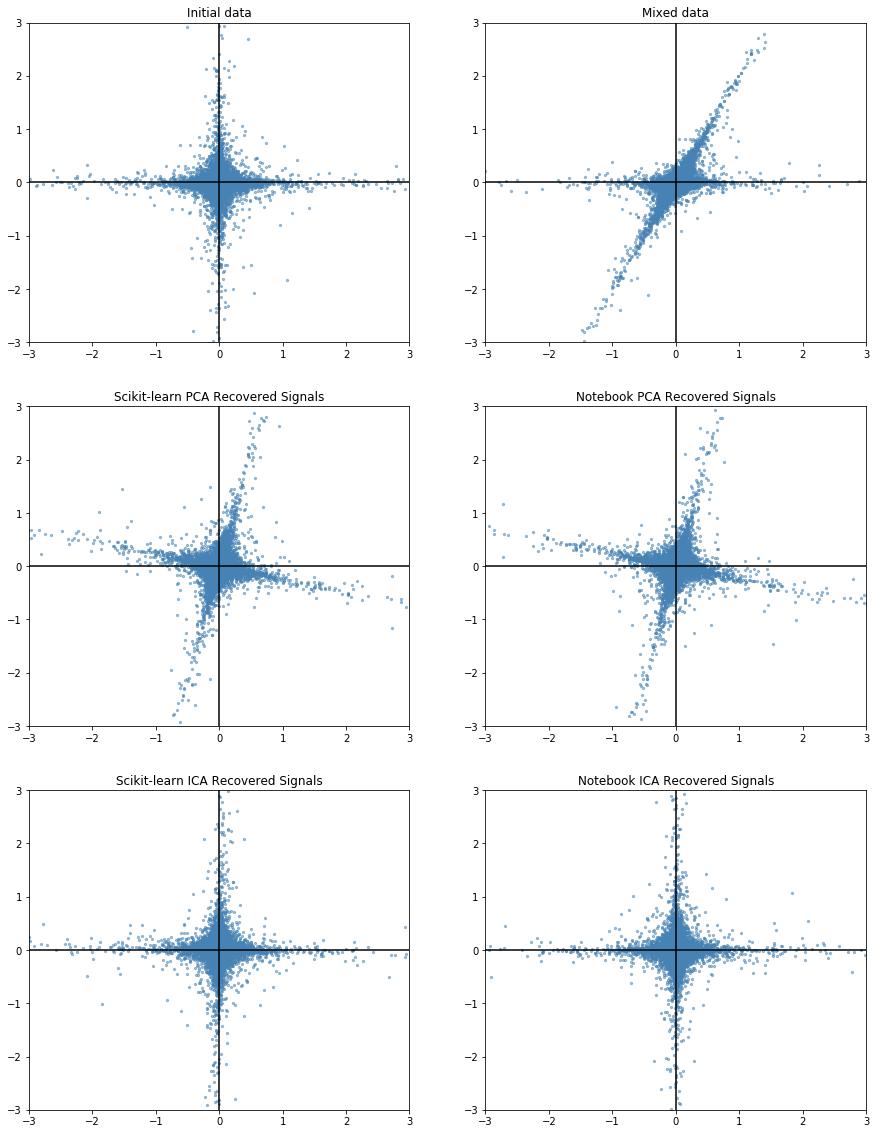

In [8]:
dummy_test()

In [26]:
# Import training images
X, y = read_images("training_set")
# Preprocess training images
X = center(X); X = standardize(X)
# PCA
PC = get_principal_components(X, 270, True)
# ICA
X = X @ PC
#IC1 = get_independent_components1(X, 270)
IC2 = get_independent_components2(X, 270)

The cumulative variance of the first 270 principal components is: 98.55830156287358


In [28]:
# Import gallery images
X_gal, y_gal = read_images("gallery")
# Proprocess gallery images
X_gal = center(X_gal); X_gal = standardize(X_gal)
# Project gallery images onto Principal and Independent Component spaces
X_gal_pca = X_gal @ PC
#X_gal_ica1 = X_gal_pca @ IC1.T
X_gal_ica2 = X_gal_pca @ IC2.T

In [ ]:
# Import FB probe images
X_fb, y_fb = read_images("fb")
# Preprocess FB probe images
X_fb = center(X_fb); X_fb = standardize(X_fb)
# Project FB probe images onto Principal and Independent Component spaces
X_fb_pca = X_fb @ PC.T
X_fb_ica2 = X_fb_pca @ IC2.T

In [17]:
# Import FC probe images
X_fc, y_fc = read_images("fc")
# Preprocess FC probe images
X_fc = center(X_fc); X_fc = standardize(X_fc)
# Project Fc probe images onto Principal and Independent Component spaces
X_fc_pca = X_fc @ PC
X_fc_ica2 = X_fc_pca @ IC2.T

In [18]:
# Import DUP1 probe images
X_dup1, y_dup1 = read_images("dup1")
# Preprocess DUP1 probe images
X_dup1 = center(X_dup1); X_dup1 = standardize(X_dup1)
# Project DUP1 probe images onto Principal and Independent Component spaces
X_dup1_pca = X_dup1 @ PC
X_dup1_ica2 = X_dup1_pca @ IC2.T

In [19]:
# Import DUP2 probe images
X_dup2, y_dup2 = read_images("dup2")
# Preprocess DUP2 probe images
X_dup2 = center(X_dup2); X_dup2 = standardize(X_dup2)
# Project DUP2 probe images onto Principal and Independent Component spaces
X_dup2_pca = X_dup2 @ PC
X_dup2_ica2 = X_dup2_pca @ IC2.T

In [24]:
# Fit PCA Nearest Neighbor classifiers
l1_pca = NearestNeighbors(n_neighbors=1, metric="l1").fit(X_gal_pca)
l2_pca = NearestNeighbors(n_neighbors=1, metric="l2").fit(X_gal_pca)
mah_pca = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(X_gal_pca.T)}).fit(X_gal_pca)
cos_pca = NearestNeighbors(n_neighbors=1, metric="cosine").fit(X_gal_pca)
# Fit ICA2 Nearest Neighbor classifiers
l1_ica2 = NearestNeighbors(n_neighbors=1, metric="l1").fit(X_gal_ica2)
l2_ica2 = NearestNeighbors(n_neighbors=1, metric="l2").fit(X_gal_ica2)
mah_ica2 = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(X_gal_ica2.T)}).fit(X_gal_ica2)
cos_ica2 = NearestNeighbors(n_neighbors=1, metric="cosine").fit(X_gal_ica2)

In [22]:
print("PCA+L1: " + str(performance(l1_pca, X_fb_pca, y_fb, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_fb_pca, y_fb, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_fb_pca, y_fb, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_fb_pca, y_fb, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 74.23%
PCA+L2: 66.03%
PCA+MAH: 51.97%
PCA+COS: 68.95%


In [24]:
print("PCA+L1: " + str(performance(l1_ica2, X_fb_ica2, y_fb, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_ica2, X_fb_ica2, y_fb, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_ica2, X_fb_ica2, y_fb, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_ica2, X_fb_ica2, y_fb, X_gal_ica2, y_gal, 1)) + "%")

PCA+L1: 57.07%
PCA+L2: 59.83%
PCA+MAH: 51.97%
PCA+COS: 76.82%


In [25]:
print("PCA+L1: " + str(performance(l1_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_fc_pca, y_fc, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 59.28%
PCA+L2: 28.87%
PCA+MAH: 45.36%
PCA+COS: 37.63%


In [26]:
print("PCA+L1: " + str(performance(l1_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_ica2, X_fc_ica2, y_fc, X_gal_ica2, y_gal, 1)) + "%")

PCA+L1: 30.41%
PCA+L2: 43.81%
PCA+MAH: 45.36%
PCA+COS: 62.89%


In [27]:
print("PCA+L1: " + str(performance(l1_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_dup1_pca, y_dup1, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 32.27%
PCA+L2: 19.53%
PCA+MAH: 21.88%
PCA+COS: 23.96%


In [28]:
print("PCA+L1: " + str(performance(l1_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_ica2, X_dup1_ica2, y_dup1, X_gal_ica2, y_gal, 1)) + "%")

PCA+L1: 29.22%
PCA+L2: 28.95%
PCA+MAH: 21.88%
PCA+COS: 39.89%


In [29]:
print("PCA+L1: " + str(performance(l1_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_pca, X_dup2_pca, y_dup2, X_gal_pca, y_gal, 1)) + "%")

PCA+L1: 20.51%
PCA+L2: 10.68%
PCA+MAH: 11.11%
PCA+COS: 14.53%


In [30]:
print("PCA+L1: " + str(performance(l1_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+L2: " + str(performance(l2_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+MAH: " + str(performance(mah_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")
print("PCA+COS: " + str(performance(cos_ica2, X_dup2_ica2, y_dup2, X_gal_ica2, y_gal, 1)) + "%")

PCA+L1: 17.95%
PCA+L2: 17.52%
PCA+MAH: 11.11%
PCA+COS: 35.9%


In [19]:
nn_l1 = NearestNeighbors(n_neighbors=1, metric="l1")
nn_l1.fit(gallery)
print(str(performance(nn_l1, fb, gallery, 1)) + " %")

74.14 %


In [20]:
nn_l2 = NearestNeighbors(n_neighbors=1, metric="l2")
nn_l2.fit(gallery)
print(str(performance(nn_l2, fb, gallery, 1)) + " %")

72.97 %


In [21]:
nn_mah = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(gallery.T)})
nn_mah.fit(gallery)
print(str(performance(nn_mah, fb, gallery, 1)) + " %")

60.84 %


In [22]:
nn_cos = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_cos.fit(gallery)
print(str(performance(nn_cos, fb, gallery, 1)) + " %")

74.48 %


In [23]:
CMS_fb = pd.DataFrame()

In [25]:
CMS_fb["PCA_L1"] = CSM(nn_l1, fb, gallery)
CMS_fb["PCA_L2"] = CSM(nn_l2, fb, gallery)
CMS_fb["PCA_COS"] = CSM(nn_cos, fb, gallery)
CMS_fb["PCA_MAH"] = CSM(nn_mah, fb, gallery)

In [27]:
CMS_fb = CMS_fb.reset_index().rename(columns={'index':'rank'})
CMS_fb['rank'] *= 5
CMS_fb.at[0, 'rank'] = 1

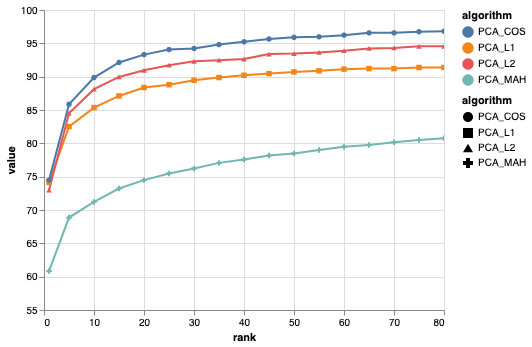

In [29]:
CMS_fb = pd.melt(CMS_fb, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fb).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(55, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [30]:
nn_l1 = NearestNeighbors(n_neighbors=1, metric="manhattan")
nn_l1.fit(gallery)
print(str(performance(nn_l1, fc, gallery, 1)) + " %")

65.98 %


In [31]:
nn_l2 = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn_l2.fit(gallery)
print(str(performance(nn_l2, fc, gallery, 1)) + " %")

53.09 %


In [32]:
nn_mah = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(gallery.T)})
nn_mah.fit(gallery)
print(str(performance(nn_mah, fc, gallery, 1)) + " %")

52.58 %


In [33]:
nn_cos = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_cos.fit(gallery)
print(str(performance(nn_cos, fc, gallery, 1)) + " %")

45.88 %


In [42]:
CMS_fc = pd.DataFrame()

In [43]:
CMS_fc["PCA_L1"] = CSM(nn_l1, fc, gallery)
CMS_fc["PCA_L2"] = CSM(nn_l2, fc, gallery)
CMS_fc["PCA_COS"] = CSM(nn_cos, fc, gallery)
CMS_fc["PCA_MAH"] = CSM(nn_mah, fc, gallery)

In [44]:
CMS_fc = CMS_fc.reset_index().rename(columns={'index':'rank'})
CMS_fc['rank'] *= 5
CMS_fc.at[0, 'rank'] = 1

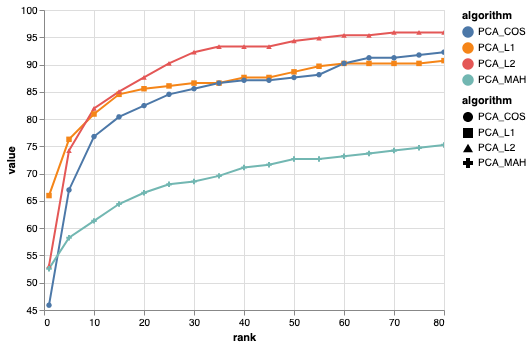

In [46]:
CMS_fc = pd.melt(CMS_fc, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_fc).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(45, 100))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [47]:
nn_l1 = NearestNeighbors(n_neighbors=1, metric="manhattan")
nn_l1.fit(gallery)
print(str(performance(nn_l1, dup1, gallery, 1)) + " %")

32.41 %


In [48]:
nn_l2 = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn_l2.fit(gallery)
print(str(performance(nn_l2, dup1, gallery, 1)) + " %")

29.5 %


In [50]:
nn_mah = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(gallery.T)})
nn_mah.fit(gallery)
print(str(performance(nn_mah, dup1, gallery, 1)) + " %")

24.52 %


In [52]:
nn_cos = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_cos.fit(gallery)
print(str(performance(nn_cos, dup1, gallery, 1)) + " %")

30.19 %


In [53]:
CMS_dup1 = pd.DataFrame()

In [54]:
CMS_dup1["PCA_L1"] = CSM(nn_l1, dup1, gallery)
CMS_dup1["PCA_L2"] = CSM(nn_l2, dup1, gallery)
CMS_dup1["PCA_COS"] = CSM(nn_cos, dup1, gallery)
CMS_dup1["PCA_MAH"] = CSM(nn_mah, dup1, gallery)

In [55]:
CMS_dup1 = CMS_dup1.reset_index().rename(columns={'index':'rank'})
CMS_dup1['rank'] *= 5
CMS_dup1.at[0, 'rank'] = 1

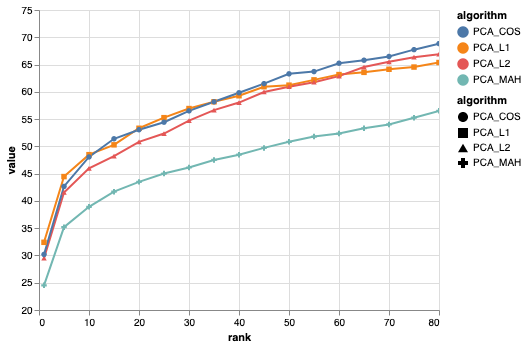

In [58]:
CMS_dup1 = pd.melt(CMS_dup1, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_dup1).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(20, 75))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [59]:
nn_l1 = NearestNeighbors(n_neighbors=1, metric="manhattan")
nn_l1.fit(gallery)
print(str(performance(nn_l1, dup2, gallery, 1)) + " %")

31.2 %


In [60]:
nn_l2 = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn_l2.fit(gallery)
print(str(performance(nn_l2, dup2, gallery, 1)) + " %")

23.08 %


In [61]:
nn_mah = NearestNeighbors(n_neighbors=1, metric="mahalanobis", metric_params={'V': np.cov(gallery.T)})
nn_mah.fit(gallery)
print(str(performance(nn_mah, dup2, gallery, 1)) + " %")

23.5 %


In [62]:
nn_cos = NearestNeighbors(n_neighbors=1, metric="cosine")
nn_cos.fit(gallery)
print(str(performance(nn_cos, dup2, gallery, 1)) + " %")

17.95 %


In [63]:
CMS_dup2 = pd.DataFrame()

In [64]:
CMS_dup2["PCA_L1"] = CSM(nn_l1, dup2, gallery)
CMS_dup2["PCA_L2"] = CSM(nn_l2, dup2, gallery)
CMS_dup2["PCA_COS"] = CSM(nn_cos, dup2, gallery)
CMS_dup2["PCA_MAH"] = CSM(nn_mah, dup2, gallery)

In [65]:
CMS_dup2 = CMS_dup2.reset_index().rename(columns={'index':'rank'})
CMS_dup2['rank'] *= 5
CMS_dup2.at[0, 'rank'] = 1

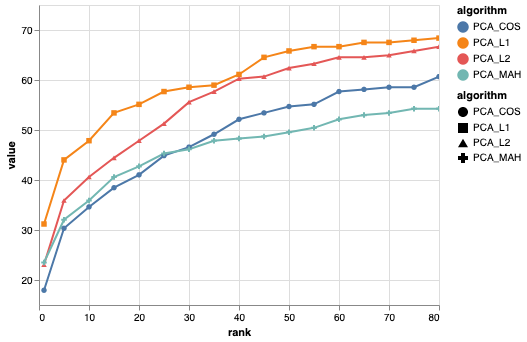

In [66]:
CMS_dup2 = pd.melt(CMS_dup2, id_vars=['rank'], value_vars=['PCA_L1', 'PCA_L2', 'PCA_COS', 'PCA_MAH']).rename(columns={'variable': 'algorithm'})

alt.Chart(CMS_dup2).mark_line().encode(
    alt.X('rank:Q'),
    alt.Y('value:Q', scale=alt.Scale(domain=(15, 75))),
    alt.Color('algorithm:N'),
    alt.Shape('algorithm:N'),
    alt.Tooltip('value:Q')
).interactive()

In [ ]:
# Plot rows of 10 images from a dataset
def plot_images(n_rows, X, title):
    fig, axes = plt.subplots(n_rows, 10, figsize=(17, 2), subplot_kw={"xticks":[], "yticks":[]})
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(60, 50))
    fig.suptitle(title)